In [1]:
# ! pip install "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

# 'COLAB_TPU_ADDR' in os.environ, 'google.colab' in str(get_ipython())

# import jax
# jax.devices()

In [2]:
# ! nvcc --version
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [3]:
# from google.colab import drive
# drive.mount("/content/gdrive")

# %cd /content/gdrive/MyDrive/Projects/lensing-minimal/notebooks

# ! pip install einops scikit-image lenstronomy
# ! pip install git+https://github.com/adam-coogan/jaxinterp2d.git@master
# ! pip install flax numpyro distrax corner
# ! pip install objax

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import vmap, jit
from einops import rearrange, repeat
from scipy.stats import norm, multivariate_normal

%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
from jax.config import config
# config.update("jax_enable_x64", True)

In [7]:
import sys
sys.path.append("../")
from lensing_sim.lensing import LensingSim

In [8]:
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic, interp
from gigalens.jax.profiles.mass import epl, shear, sie

In [9]:
plt.rcParams.update({
  "text.usetex": True,
})

In [10]:
cmap = 'magma'
cmap_resid = 'RdGy'

## Configuration

In [11]:
## Image configuration

image_extent = 5  # Size of image in arcmin
n_xy = 500  # Number of pixels

n_sup = 1  # Supersampling of source factor
n_xy_s = int(n_sup * n_xy)

fwhm_psf = 0.005  # ELT FWHM of 5 mas from 1903.04742

In [12]:
## MLP configuration

num_dense_layers = 4
dense_layer_width = 256
add_positional_encoding = True
positional_encoding_dims = 5
add_random_fourier = False
B = 5.
add_skip_connection = False

In [13]:
## RNG; set to fixed values for deterministic run
key_model = 42  # np.random.randint(1000)
key_train = 43  # np.random.randint(1000)

In [14]:
n_q_samples = 64  # Number of MC samples to build ELBO expectation

In [15]:
## Training configuration

learning_rate_init = 1e-3
learning_rate_variational = 1e-3
weight_decay = 1e-4
momentum = 0.5
optimizer_name = "adamw"

train_epochs = 15000
warmup_steps = 2000
plot_every = 200

## Source image

In [16]:
import os
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
from urllib import request

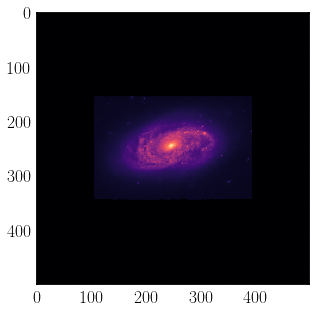

In [17]:
galaxy_url = "https://cdn.spacetelescope.org/archives/images/large/potw2015a.jpg"
galaxy_name = "NGC2906"

if not os.path.exists("{}.jpg".format(galaxy_name)):
    request.urlretrieve(galaxy_url, "{}.jpg".format(galaxy_name))

im_source = np.asarray(Image.open("{}.jpg".format(galaxy_name)).convert('L'))

im_source_temp = np.zeros((np.max(im_source.shape), np.max(im_source.shape)))
im_source_temp[int(im_source.shape[1] / 2 - im_source.shape[0] / 2):int(im_source.shape[1] / 2 + im_source.shape[0] / 2), :] = im_source
im_source = im_source_temp
im_source = im_source - np.min(im_source)
im_source = im_source / np.max(im_source)
im_source = np.pad(im_source, (1024, 1024))
im_source = resize(im_source, (n_xy_s, n_xy_s), anti_aliasing=True)
im_source[im_source < 0.05] = 0.
plt.imshow(im_source , cmap=cmap)


## Lensed image

In [18]:
sigma_psf = fwhm_psf / 2 ** 1.5 * np.sqrt(np.log(2))  # Convert FWHM to standard deviation

In [19]:
## Make Gaussian PSF kernel

delta_pix = image_extent / n_xy

x_kern = np.linspace(-6, 6, 13)
x, y = np.meshgrid(x_kern, x_kern)
kernel = multivariate_normal(mean=np.zeros(2), cov=np.ones(2) * sigma_psf / delta_pix).pdf(np.dstack((x, y)))
kernel /= np.sum(kernel)

# plt.imshow(kernel)

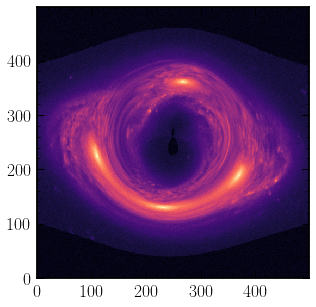

In [20]:
## Lensed image

# Supersample to reduce artifacting
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=n_xy_s, supersample=8, kernel=kernel)
coord_half = sim_config.delta_pix * sim_config.num_pix / 2
x_lims = [-coord_half, coord_half]
y_lims = [-coord_half, coord_half]
phys_model = PhysicalModel([sie.SIE(), shear.Shear()], [], [interp.Interp()])

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

truth = [[
    {'theta_E': 1.3, 'e1': 0.2, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.0},
    {'gamma1': -0.02, 'gamma2': 0.02}
], [ 
    {'img': im_source, 'x_lims': x_lims, 'y_lims': y_lims}
]]

std_noise = 1.e-6
image = lens_sim.simulate(truth)
image += std_noise * np.random.randn(*image.shape)
image = image.reshape(-1, n_sup, image.shape[-1] // n_sup, n_sup).sum((-1, -3))

# Revert supersampling for forward simulator
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=n_xy_s, supersample=1, kernel=kernel)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

plt.imshow(image.T, origin='lower' , cmap=cmap)

In [21]:
## SNR around lens
np.median(image[image > 0.5 * image.max()] / std_noise)

55.68799

In [22]:
# Max SNR
image.max() / std_noise

DeviceArray(96.44253, dtype=float32)

## Rendering function wrapper

In [23]:
def render_lens(inputs):
    
    samples_src, samples_lens_params, x_lims, y_lims = inputs
    
    theta_E, theta_x, theta_y, e_1, e_2, gamma_1, gamma_2 = samples_lens_params
    
    truth = [[
        {'theta_E': theta_E, 'e1': e_1, 'e2': e_2, 'center_x': theta_x, 'center_y': theta_y},
        {'gamma1': gamma_1, 'gamma2': gamma_2}
    ], [ 
        {'img': samples_src, 'x_lims': x_lims, 'y_lims': y_lims}
    ]]

    image = lens_sim.simulate(truth)
    lens_sim.simulate(truth)
    
    return image

In [24]:
render_lens_vmapped = vmap(jit(render_lens))

## NeRF

In [25]:
def positional_encoding(inputs, positional_encoding_dims=positional_encoding_dims):
    """ Sinusoidal positional encodings
    """
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

In [26]:
from typing import Any

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

In [27]:
n_lens_params = 7

In [28]:
def initial_scale_tri_params(key):   
    """ Initial Cholesky matrix lensparams
    """
    ary = -7. * jnp.ones(int(n_lens_params * (n_lens_params + 1) / 2))
    ary = ary.at[:-n_lens_params].set(0.)
    return ary

def initial_loc_params(key):
    """ Initial mean lens params
    """
    return jnp.array([1.5, 0., 0., 0.0, 0.0, 0.0, 0.0])

class NeRFModel(nn.Module):
    """ NeRF MLP
    """ 
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, input_points):
        
        loc = self.param('loc_params', initial_loc_params)
        scale_tri = self.param('scale_tri_params', initial_scale_tri_params)
                
        # Apply positional encodings or random Fourier features (but not both) to the input points

        if add_positional_encoding and add_random_fourier:
            raise NotImplementedError("Can't have both positional encodings and RFFs")
            
        if add_positional_encoding:
            x = positional_encoding(input_points)
        elif add_random_fourier:
            x = nn.Dense(dense_layer_width, dtype=self.dtype, kernel_init=nn.initializers.normal(stddev=B / 2.), bias_init=nn.initializers.uniform(scale=1))(input_points)
            x = jnp.sin(2 * np.pi * x)
        else:
            x = input_points

        for i in range(num_dense_layers):
                                    
            # Fully-connected layer
            x = nn.Dense(
                dense_layer_width,
                dtype=self.dtype,
            )(x)
                        
            # Activation function
            x = nn.relu(x)
            
            if add_skip_connection: # Skip connection
                x = jnp.concatenate([x, input_points], axis=-1) if i in [4] else x

        x = nn.Dense(2, dtype=self.dtype)(x)
        return x, loc, scale_tri

In [29]:
def initialize_model(key, input_pts_shape):
    # Create an instance of the model
    model = NeRFModel()

    # Initialize the model parameters
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    
    return model, initial_params["params"]

In [30]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(np.random.randint(1000)))

# Initialize the Model
model, params = initialize_model(key, (n_xy_s * n_xy_s, 2))

In [31]:
input_to_network = jnp.ones((n_xy_s * n_xy_s, 2))

In [32]:
model.apply({"params": params}, input_to_network)

(DeviceArray([[-0.06598361, -0.28689578],
              [-0.06598361, -0.28689578],
              [-0.06598361, -0.28689578],
              ...,
              [-0.06598361, -0.28689578],
              [-0.06598361, -0.28689578],
              [-0.06598361, -0.28689578]], dtype=float32),
 DeviceArray([1.5, 0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 DeviceArray([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -7., -7., -7.,
              -7., -7., -7., -7.], dtype=float32))

In [33]:
"The model has {} parameters".format(sum(x.size for x in jax.tree_leaves(params)))

'The model has 203813 parameters'

In [34]:
theta_x_lims = theta_y_lims = x_lims
theta_x_coords, theta_y_coords = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_xy_s), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_xy_s))

coords = jnp.array([theta_x_coords, theta_y_coords])
image_input =  jnp.expand_dims(image, 0)

In [35]:
lct = dist.transforms.SoftplusLowerCholeskyTransform()

scale_tri = lct(initial_scale_tri_params(key))
scale_tri

DeviceArray([[0.00091147, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.00091147, 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.00091147, 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.00091147, 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.00091147,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.00091147, 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.00091147]], dtype=float32)

In [36]:
import functools
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

@functools.partial(jax.jit, static_argnums=3)
def train_step(state, batch, key, learning_rate_fn):
    """ Single train step
    """
    # Unravel the inputs and targets from the batch
    inputs, targets = batch
    inputs = rearrange(inputs, "c h w -> (h w) c")
    
    # jitter = jax.random.normal(key, shape=(2,)) * sim_config.delta_pix / 2.
    jitter = jax.random.normal(key, shape=(2,)) * 0. / 4.  # No jitter
    
    inputs = inputs + jitter[jnp.newaxis, :]
    
    key_lens, key_source = jax.random.split(key)
    
    # Compute the loss in a stateless manner
    def loss_fn(params):
        # Create the model function from the train state
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        model_output, loc, scale_tri = model_fn(inputs)
                        
        model_output = rearrange(model_output, "(h w) mus -> mus (h w)", h=n_xy_s, w=n_xy_s)
        
        ## Lens param loss
        
        # Lens variational distribution
        scale_tri = lct(scale_tri)
        dist_lens = dist.MultivariateNormal(loc=loc, scale_tril=scale_tri)
        
        # Lens prior
        dist_prior_lens_unif = dist.Uniform(low=jnp.array([1., -0.5, -0.5]), high=jnp.array([2., 0.5, 0.5]))
        dist_prior_lens_norm = dist.Normal(loc=jnp.array([0., 0., 0., 0.]), scale=jnp.array([0.3, 0.3, .05, 0.05]))
        
        # MC samples of lens parameters
        samples_lens = dist_lens.sample(key=key_lens, sample_shape=(n_q_samples,))
        
        
        loss_q_lens = jnp.sum(dist_lens.log_prob(samples_lens)) / n_q_samples                        
        loss_prior_lens = -jnp.sum(dist_prior_lens_unif.log_prob(samples_lens[:, :-4])) / n_q_samples \
                            -jnp.sum(dist_prior_lens_norm.log_prob(samples_lens[:, -4:])) / n_q_samples \

        ## Source param loss
        
        # Source variational distribution
        mu, sigma = nn.softplus(model_output[0]), nn.softplus(model_output[1])
        dist_source = dist.Normal(mu, sigma)  
        
        # Source prior
        dist_prior_source = dist.HalfNormal(scale=1. * jnp.ones_like(mu))
        
        # Source MC samples
        samples_source = dist_source.sample(key=key_source, sample_shape=(n_q_samples,))
        # samples_source = repeat(im_source, "h w -> s (h w)", s=n_q_samples)  # If testing with true source
        
        loss_q_source = jnp.sum(dist_source.log_prob(samples_source)) / n_q_samples
        loss_prior_source = -jnp.sum(dist_prior_source.log_prob(samples_source)) / n_q_samples
                
        samples_source = rearrange(samples_source, "s (h w) -> s h w", h=n_xy_s, w=n_xy_s)
        
        x_lims = repeat(jnp.array([-coord_half, coord_half]) + jitter[0], "xx -> nq xx", nq=n_q_samples)
        y_lims = repeat(jnp.array([-coord_half, coord_half]) + jitter[1], "yy -> nq yy", nq=n_q_samples)
        
        # Render lens and compute log-prob
        lenses = render_lens_vmapped((samples_source, samples_lens, x_lims, y_lims))
        lenses = lenses.reshape(lenses.shape[0], lenses.shape[-1] // n_sup, n_sup, lenses.shape[-1] // n_sup, n_sup).sum((-1, -3))
        
        # Compute log-probability
        loss_likelihood = -jnp.sum(dist.Normal(targets, std_noise).log_prob(lenses)) / n_q_samples
            
        return  loss_q_source + loss_prior_source + loss_q_lens + loss_prior_lens + loss_likelihood
    
    # Transform the loss function to get the loss value and the gradients
    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    
    # Updated the model params and the optimizer state
    new_state = state.apply_gradients(grads=gradients)
    
    # Mean of train loss of the batch
    train_loss = jnp.mean(train_loss)
    
    lr = learning_rate_fn(state.step)
    
    return train_loss, new_state

In [37]:
lr_schedule = optax.warmup_cosine_decay_schedule(init_value=0, peak_value=learning_rate_init, warmup_steps=warmup_steps, decay_steps=train_epochs - warmup_steps)
lr_schedule_variational = optax.warmup_cosine_decay_schedule(init_value=0, peak_value=learning_rate_variational, warmup_steps=warmup_steps, decay_steps=train_epochs - warmup_steps)

In [38]:
def map_nested_fn(fn):
    '''Recursively apply `fn` to the key-value pairs of a nested dict'''
    def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v)) for k, v in nested_dict.items()}
    return map_fn

In [39]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(key_model))

# Initialize the Model
model, params = initialize_model(key, (n_xy_s * n_xy_s, 2))

# Define the Optimizer
if optimizer_name == "adamw":
    optimizer = optax.adamw(learning_rate=lr_schedule, weight_decay=weight_decay)
elif optimizer_name == "sgdm":
    optimizer = optax.sgd(learning_rate=lr_schedule, momentum=momentum, nesterov=True)
elif optimizer_name == "adabelief":
    optimizer = optax.adabelief(learning_rate=lr_schedule)
else:
    raise NotImplementedError

optimizer_variational = optax.adabelief(learning_rate=lr_schedule_variational)

# # Create the Training State
label_fn = map_nested_fn(lambda k, _: "mlp" if k in ["w", "b"] else "var_params")
tx = optax.multi_transform({'mlp': optimizer, 'var_params': optimizer_variational}, label_fn)
params = params.unfreeze()
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Function for executing the train and validation loop
def train_and_evaluate(state, train_step_fn, learning_rate_fn):
        
    train_loss_history, reconstructed_src_mu_history, reconstructed_src_std_history, reconstructed_lens_history = [], [], [], []
    loc_history, scale_tri_history = [], []
    key, rng = jax.random.split(jax.random.PRNGKey(key_train))
    
    for epoch in tqdm(range(train_epochs)):
                
        train_batch = coords, image_input

        # Perform the Training Step
        key, rng = jax.random.split(key)
        train_loss, state = train_step_fn(state, train_batch, key, learning_rate_fn)
                      
        train_loss_history.append(np.asarray(np.mean(train_loss)))

        # Plot the result every plot interval
        if epoch % plot_every == 0:    
            
            model_fn = lambda x: state.apply_fn({"params": state.params}, x)
            model_output, loc, scale_tri = model_fn(rearrange(coords, "c h w -> (h w) c"))
            model_output = rearrange(model_output, "(h w) c -> c h w", h=n_xy_s, w=n_xy_s)
                        
            lenses = render_lens((nn.softplus(model_output[0]), loc, x_lims, y_lims))
            lenses = lenses.reshape(lenses.shape[-1] // n_sup, n_sup, lenses.shape[-1] // n_sup, n_sup).sum((-1, -3))

            reconstructed_lens_history.append(np.asarray(lenses.T))
            reconstructed_src_mu_history.append(np.asarray(nn.softplus(model_output[0])))
            reconstructed_src_std_history.append(np.asarray(nn.softplus(model_output[1])))
            
            loc_history.append(np.asarray(loc))
            scale_tri_history.append(np.asarray(scale_tri))
    
    hist = {
        "train_loss": train_loss_history,
        "reconstructed_lens": reconstructed_lens_history,
        "reconstructed_src_mu": reconstructed_src_mu_history,
        "reconstructed_src_std": reconstructed_src_std_history,
        "loc_history": loc_history,
        "scale_tri_history": scale_tri_history
    }
    
    return state, hist

In [96]:
state, hist = train_and_evaluate(state, train_step, lr_schedule)

100%|██████████| 15000/15000 [33:39<00:00,  7.43it/s]


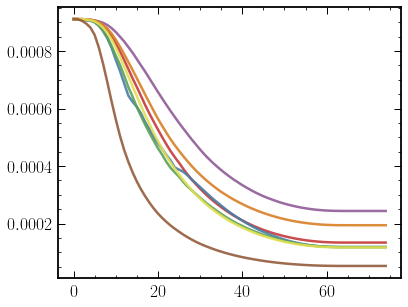

In [97]:
# Plot lens param variances vs train step

for j in range(n_lens_params):
    plt.plot([jnp.diag(lct(hist['scale_tri_history'][i]))[j] for i in range(len(hist['loc_history']))])

In [98]:
jnp.diag(lct(hist['scale_tri_history'][-1]))

DeviceArray([1.33660302e-04, 1.18011652e-04, 1.18057011e-04,
             2.43655944e-04, 1.94054854e-04, 1.16658775e-04,
             5.22957562e-05], dtype=float32)

In [99]:
hist['loc_history'][-1]

array([ 1.3000908e+00,  9.9887654e-02, -3.5971610e-05,  1.9988918e-01,
        1.0028992e-01, -2.0038836e-02,  2.0149540e-02], dtype=float32)

## Corner plot

In [100]:
post_lens = dist.MultivariateNormal(loc=hist['loc_history'][-1], scale_tril=lct(hist['scale_tri_history'][-1]))
post_lens_samples = np.asarray(post_lens.sample(key=key, sample_shape=(10000,)))

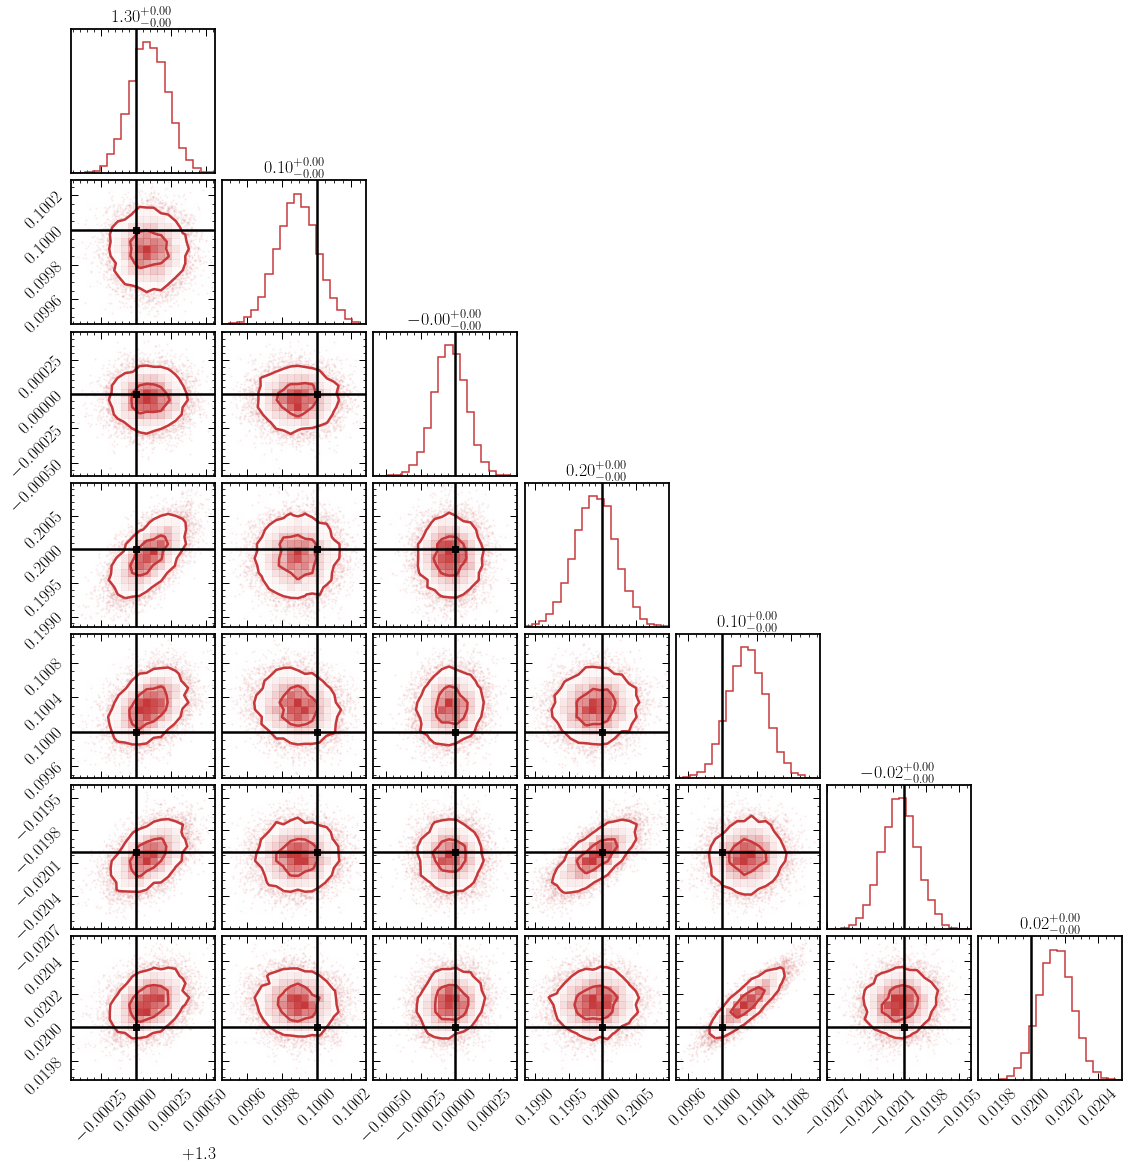

In [101]:
import corner

levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

truths = [truth[0][0]['theta_E'], 
                     truth[0][0]['center_x'], 
                     truth[0][0]['center_y'], 
                     truth[0][0]['e1'],
                     truth[0][0]['e2'],
                     truth[0][1]['gamma1'],
                     truth[0][1]['gamma2']]

corner.corner(post_lens_samples, truths=truths,
                          bins=20, 
                          # quantiles=[0.16, 0.84],
                          show_titles=True,
                          color=cols_default[0],
                          levels=levels,
                          use_math_text=True, 
                          hist_kwargs={'alpha':1, 'lw':1.5}, 
                          alpha=0.1, truth_color='k',
);

## Paper Figure 2

In [53]:
labels = [r"$\theta_\mathrm{E}$",
          r"$\theta_x$",
          r"$\theta_y$",
          r"$\epsilon_1$",
          r"$\epsilon_2$",
          r"$\gamma_1$",
          r"$\gamma_2$",]          

In [54]:
suptitles = [r"\bf{Einstein radius\,[$''$]}",
 r"\bf{Lens-source offsets\,[$''$]}",
 r"",
 r"\bf{Lens eccentricities}",
 r"",
 r"\bf{External shear}",
 r""]

In [50]:
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D

def plot_fisher_single(i ,cov, mu, ax, lims, truths, labels) :
    nb=128
    sigma=np.sqrt(cov[i,i])
    x_arr=mu[i]-8*sigma+16*sigma*np.arange(nb)/(nb-1.)
    p_arr=np.exp(-(x_arr-mu[i])**2/(2*sigma**2))
    ax.plot(x_arr,p_arr, color=cols_default[0])    
    ax.axvline(truths[i], color='darkgrey', lw=1.5)
    ax.set_xlim(lims[0][i], lims[1][i])
    ax.set_ylim(-0.02, 1.2)
    ax.set_title(labels[i], fontsize=18.5, y=1.02)
    
    if i == 0:
        custom_lines = [Line2D([0], [0], color=cols_default[0], lw=4),
                Line2D([0], [0], color='darkgrey', lw=4)]
        
        ax.legend(custom_lines, ["Posterior", "Truth"], bbox_to_anchor=[6, 0.5], frameon=True, fancybox=True, fontsize=19)


def plot_fisher_two(i1, i2, cov, mu, ax, lims, truths, labels) :
    covar=np.zeros([2,2])
    covar[0,0]=cov[i1,i1]
    covar[0,1]=cov[i1,i2]
    covar[1,0]=cov[i2,i1]
    covar[1,1]=cov[i2,i2]
    sig0=np.sqrt(covar[0,0])
    sig1=np.sqrt(covar[1,1])

    w,v=np.linalg.eigh(covar)
    
    angle=180*np.arctan2(v[1,0],v[0,0])/np.pi
    a_1s=np.sqrt(2.3*w[0])
    b_1s=np.sqrt(2.3*w[1])
    a_2s=np.sqrt(6.17*w[0])
    b_2s=np.sqrt(6.17*w[1])

    centre=np.array([mu[i1],mu[i2]])
        
    e_1s=Ellipse(xy=centre,width=2*a_1s,height=2*b_1s,angle=angle, color=cols_default[0], lw=2.)
    e_1s.set_fill(False)
    
    e_2s=Ellipse(xy=centre,width=2*a_2s,height=2*b_2s,angle=angle, ls='--', color=cols_default[0], lw=2.)
    e_2s.set_fill(False)

    ax.add_artist(e_1s)
    ax.add_artist(e_2s)
    
    ax.axvline(truths[i1], color='darkgrey', lw=1.5)
    ax.axhline(truths[i2], color='darkgrey', lw=1.5)

    ax.set_xlim(lims[0][i1], lims[1][i1])
    ax.set_ylim(lims[0][i2], lims[1][i2])
    
    ax.set_xlabel(labels[i1])
    ax.set_ylabel(labels[i2])

def plot_fisher_all(mu, cov, lims, truths, labels, suptitles): 
    n_params = len(mu)

    fig=plt.figure(figsize=(12, 12))
    plt.subplots_adjust(hspace=0, wspace=0)
    for i in np.arange(n_params):
        i_col=i
        for j in np.arange(n_params-i)+i :
            i_row=j
            iplot=i_col+n_params*i_row+1

            ax=fig.add_subplot(n_params,n_params,iplot)
            if i==j :
                plot_fisher_single(i, cov, mu, ax, lims, truths, labels)
                ax.text(0.5, 1.5, suptitles[i], 
                         horizontalalignment='left' if not i==0 else "center",
                         verticalalignment='center',
                         transform = ax.transAxes,
                         fontsize=18)

            else :
                plot_fisher_two(i, j, cov, mu, ax, lims, truths, labels)

            if i_row!=n_params-1 :
                ax.get_xaxis().set_visible(False)

            if i_col!=0 :
                ax.get_yaxis().set_visible(False)

            if i_col==0 and i_row==0 :
                ax.get_yaxis().set_visible(False)
                            
            ax.locator_params(nbins=2)
            [l.set_rotation(45) for l in ax.get_xticklabels()]
            [l.set_rotation(45) for l in ax.get_yticklabels()]

    fig.align_labels()
    
    plt.savefig("figures/joint_lens.pdf", bbox_inches='tight')

    plt.show()

i = -1

chol = lct(hist['scale_tri_history'][i])
cov = np.dot(chol, chol.T)
mu = hist['loc_history'][i]

lims = [mu - 6 * np.sqrt(np.diag(cov)), mu + 6 * np.sqrt(np.diag(cov))]

plot_fisher_all(mu, cov, lims, truths, labels, suptitles)

In [121]:
# # Save corner plot data
# np.savez("corner_data.npz",
#          mu=mu, cov=cov, lims=lims, truths=truths, labels=labels, suptitles=suptitles)

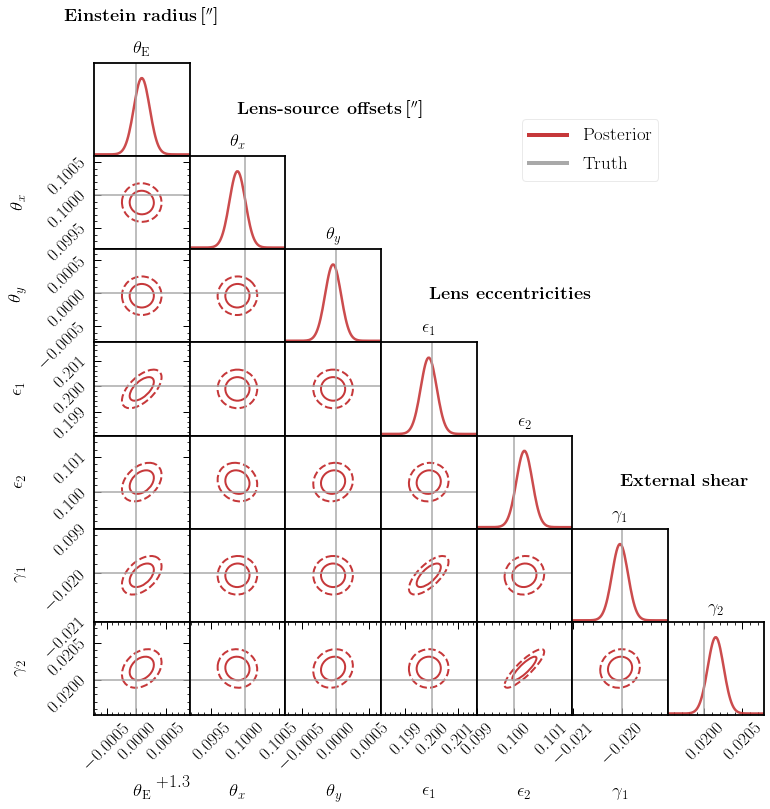

In [55]:
corner_data = np.load("corner_data.npz")
mu, cov, lims, truths, labels, suptitles = corner_data["mu"], corner_data["cov"], corner_data["lims"], corner_data["truths"], corner_data["labels"], suptitles, 
plot_fisher_all(mu, cov, lims, truths, labels, suptitles)

In [105]:
hist["train_loss"][-1] / (n_xy * n_xy)

-11.615147

(-15.0, 50.0)

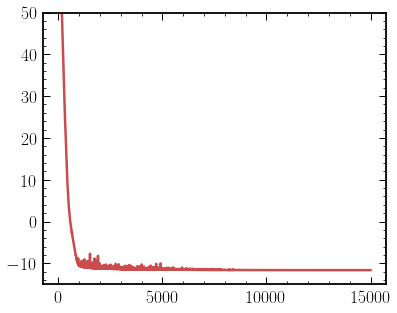

In [106]:
plt.plot(np.array(hist["train_loss"]) / (n_xy * n_xy))
plt.ylim(-15, 50)

In [109]:
snr = ((hist["reconstructed_src_mu"][-1])) / ((hist["reconstructed_src_std"])[-1]) < 5

In [110]:
hist["reconstructed_src_mu"][-1][~snr].mean()

0.1654051

In [111]:
im_source[~snr].mean()

0.1654148711552108

(-20.0, 20.0)

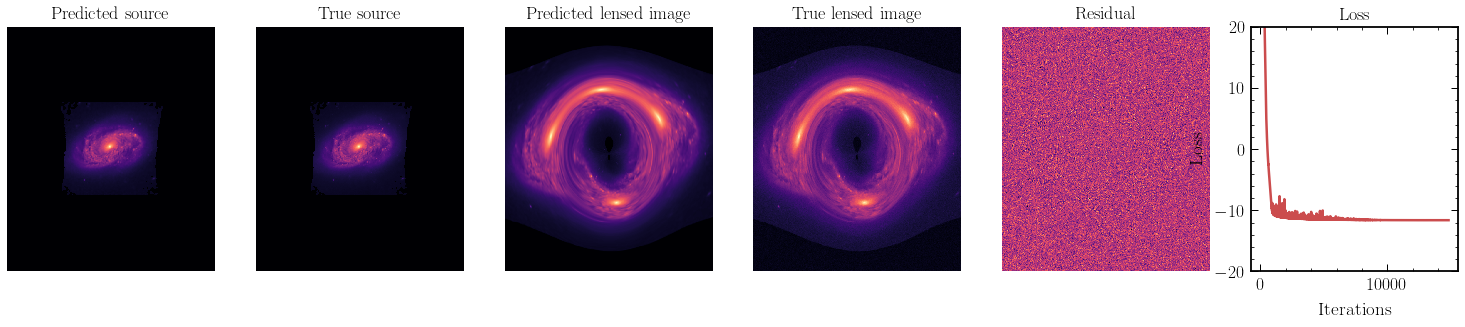

In [112]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(26, 4.5))

i = len(hist["reconstructed_src_mu"]) - 1

ax1.imshow((hist["reconstructed_src_mu"][i]) * ~snr, cmap=cmap, vmin=0, vmax=im_source.max(), aspect="auto")
# ax1.imshow(gaussian_filter(hist["reconstructed_src_mu"][i] * ~oob_cond, sigma=0.025 / pixel_size, truncate=8.), cmap=cmap, vmin=0, vmax=1, aspect="auto")
ax1.set_title(f"Predicted source")
ax1.axis("off")
ax2.imshow(im_source * ~snr, cmap=cmap, vmin=0, vmax=im_source.max(), aspect="auto")
ax2.set_title(f"True source")
ax2.axis("off")
ax3.imshow(hist["reconstructed_lens"][i], cmap=cmap, aspect="auto")
ax3.set_title(f"Predicted lensed image")
ax3.axis("off")
ax4.imshow(image_input[0].T, cmap=cmap, aspect="auto")
ax4.set_title(f"True lensed image")
ax4.axis("off")
im = ax5.imshow((hist["reconstructed_lens"][i] - image_input[0].T) / std_noise, cmap=cmap, aspect="auto", vmin=-5, vmax=5)
ax5.set_title(f"Residual")
ax5.axis("off")
ax6.plot(np.arange(plot_every * (i)), np.array(hist["train_loss"][:plot_every * (i)]) / (n_xy * n_xy))
ax6.set_title(f"Loss")
ax6.set_xlabel(f"Iterations")
ax6.set_ylabel(f"Loss")
ax6.set_ylim(-20, 20)

## Animation

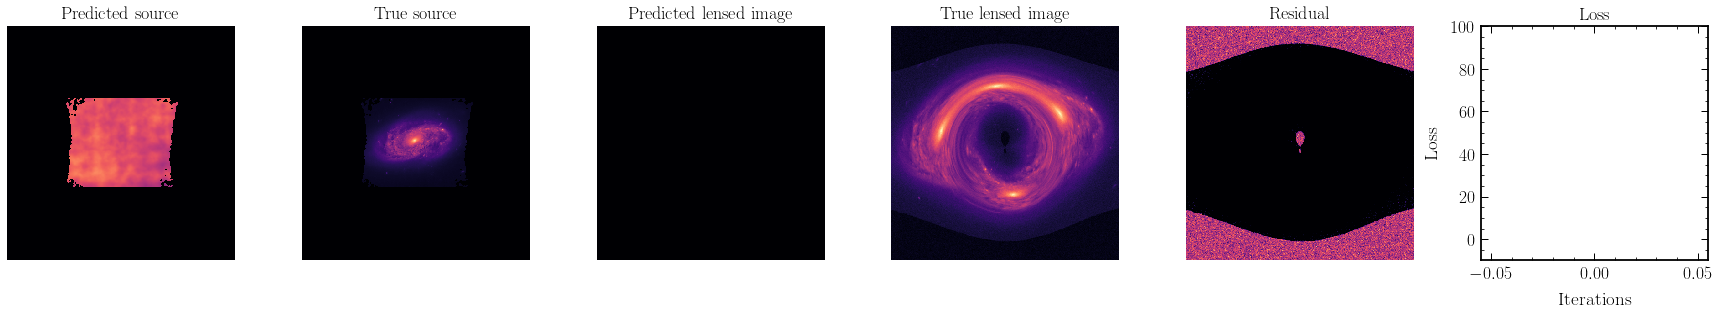

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

In [113]:
from celluloid import Camera

epoch = -1

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 4.5))
camera = Camera(fig)

for i in range(len(hist["reconstructed_lens"])):
    ax1.imshow((hist["reconstructed_src_mu"][i]) * ~snr, cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax1.set_title(f"Predicted source")
    ax1.axis("off")
    ax2.imshow(im_source * ~snr, cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax2.set_title(f"True source")
    ax2.axis("off")
    ax3.imshow(hist["reconstructed_lens"][i], cmap=cmap, aspect="auto")
    ax3.set_title(f"Predicted lensed image")
    ax3.axis("off")
    ax4.imshow(image_input[0].T, cmap=cmap, aspect="auto")
    ax4.set_title(f"True lensed image")
    ax4.axis("off")
    im = ax5.imshow((hist["reconstructed_lens"][i] - image_input[0].T) / std_noise, cmap=cmap, aspect="auto", vmin=-5, vmax=5)
    ax5.set_title(f"Residual")
    ax5.axis("off")
    ax6.plot(np.arange(plot_every * (i)), np.array(hist["train_loss"][:plot_every * (i)]) / (n_xy * n_xy), color=cols_default[0])
    ax6.set_title(f"Loss")
    ax6.set_xlabel(f"Iterations")
    ax6.set_ylabel(f"Loss")
    ax6.set_ylim(-10, 100)
    # cbar = fig.colorbar(im, ax=ax5)
    plt.tight_layout();
    plt.show()
    camera.snap()

In [114]:
animation = camera.animate()
animation.save('render.gif', fps=10)

## Paper Figure 1

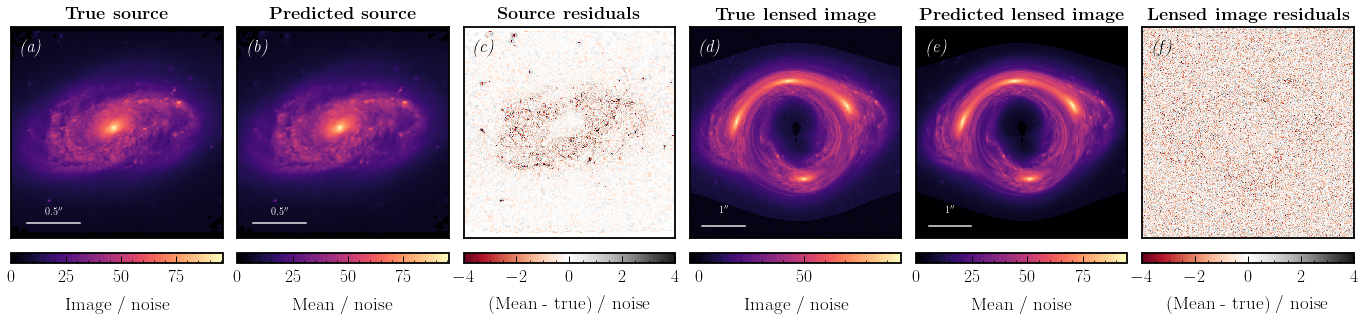

In [115]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 6, figsize=(19, 4.5))

i = -1

source_coord_limit = 1.

im_list = []

im_list.append(ax[0].imshow(im_source * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
ax[0].set_xlim(-source_coord_limit, source_coord_limit)
ax[0].set_ylim(-source_coord_limit, source_coord_limit)
ax[0].set_title(r"\bf{True source}")

im_list.append(ax[1].imshow((hist["reconstructed_src_mu"][i]) * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
ax[1].set_xlim(-source_coord_limit, source_coord_limit)
ax[1].set_ylim(-source_coord_limit, source_coord_limit)
ax[1].set_title(r"\bf{Predicted source}")

im_list.append(ax[2].imshow((hist["reconstructed_src_mu"][i] - im_source) * ~snr * lens_sim.conversion_factor / std_noise, vmin=-4, vmax=4, cmap=cmap_resid, extent=[*x_lims, *y_lims]))
ax[2].set_xlim(-source_coord_limit, source_coord_limit)
ax[2].set_ylim(-source_coord_limit, source_coord_limit)
ax[2].set_title(r"\bf{Source residuals}")

im_list.append(ax[3].imshow(image_input[0].T / std_noise, cmap=cmap, extent=[*x_lims, *y_lims]))
im_list.append(ax[4].imshow((hist["reconstructed_lens"][i]) / std_noise, cmap=cmap, extent=[*x_lims, *y_lims]))
im_list.append(ax[5].imshow((hist["reconstructed_lens"][i] - image_input[0].T) / std_noise, cmap=cmap_resid, vmin=-4, vmax=4, extent=[*x_lims, *y_lims]))

ax[3].set_title(r"\bf{True lensed image}")
ax[4].set_title(r"\bf{Predicted lensed image}")
ax[5].set_title(r"\bf{Lensed image residuals}")

for i_lens in [3, 4]:
    ax[i_lens].plot([-2.2, -1.2], [-2.2, -2.2], c="white", lw=1.5, ls="-")
    ax[i_lens].text(-1.7, -1.85, "$1''$", va="center", ha="center", color="white")

for i_src in [0, 1]:
    ax[i_src].plot([-0.85, -0.35], [-0.85, -0.85], c="white", lw=1.5, ls="-")
    ax[i_src].text(-0.6, -0.75, "$0.5''$", va="center", ha="center", color="white")

labels = ["Image / noise", "Mean / noise", "(Mean - true) / noise", "Image / noise", "Mean / noise", "(Mean - true) / noise"]
for i in range(6):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.2)
    cbar = fig.colorbar(im_list[i], cax=cax, orientation="horizontal", label=labels[i])


labels = [r'\emph{(a)}',r'\emph{(b)}',r'\emph{(c)}',r'\emph{(d)}',r'\emph{(e)}',r'\emph{(f)}']
colors = ['w','w','k','w','w','k']
for i in range(6):
    ax[i].text(0.1, 0.9, labels[i], 
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax[i].transAxes,
         color=colors[i], fontsize=17)

[axx.xaxis.set_visible(False) for axx in ax.flatten()];
[axx.yaxis.set_visible(False) for axx in ax.flatten()];

plt.tight_layout()
plt.savefig("figures/reconstruction.pdf")

In [123]:
# Save figure data
np.savez("fig1_data.npz",
         reconstructed_lens=hist["reconstructed_lens"][i], 
         reconstructed_src_mu=hist["reconstructed_src_mu"][i],
         snr=snr,
         im_source=im_source,
         image_input=image_input[0])